In [1]:
# Much of this work is inspired by the wonderful kernel 'Train Simple XRay CNN' by Kevin Mader

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # additional plotting functionality

import os
print(os.listdir("../input"))

['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']


In [3]:
xray_data = pd.read_csv('../input/Data_Entry_2017.csv')

# see how many observations there are
num_obs = len(xray_data)
print('Number of observations:',num_obs)

xray_data.head(5) 

Number of observations: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
from glob import glob

my_glob = glob('../input/images*/images/*.png')
print('Number of Observations: ', len(my_glob)) # check to make sure I've captured every pathway, should equal 112,120

Number of Observations:  112120


In [5]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)

Number of unique labels: 836
                                                    Finding Labels
No Finding                                                   60361
Infiltration                                                  9547
Atelectasis                                                   4215
Effusion                                                      3955
Nodule                                                        2705
Pneumothorax                                                  2194
Mass                                                          2139
Effusion|Infiltration                                         1603
Atelectasis|Infiltration                                      1350
Consolidation                                                 1310
Atelectasis|Effusion                                          1165
Pleural_Thickening                                            1126
Cardiomegaly                                                  1093
Emphysema                        

(<matplotlib.axes._subplots.AxesSubplot at 0x78eeca2dc7f0>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19]), <a list of 20 Text xticklabel objects>))

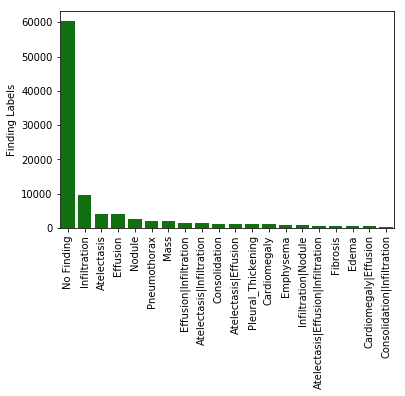

In [6]:
num_unique_labels = xray_data['Finding Labels'].nunique()
print('Number of unique labels:',num_unique_labels)

# let's look at the label distribution to better plan our next step
count_per_unique_label = xray_data['Finding Labels'].value_counts() # get frequency counts per label
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes

print(df_count_per_unique_label) # view tabular results
sns.barplot(x = df_count_per_unique_label.index[:20], y="Finding Labels", data=df_count_per_unique_label[:20], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [7]:
# define dummy labels for one hot encoding - simplifying to 14 primary classes (excl. No Finding)
dummy_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

# One Hot Encoding of Finding Labels to dummy_labels
for label in dummy_labels:
    xray_data[label] = xray_data['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
xray_data.head(20) # check the data, looking good!

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,full_path,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/images_001/images/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/images_001/images/00000001_001.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000003_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN,../input/images_001/images/00000003_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN,../input/images_001/images/00000003_003.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000003_004.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN,../input/images_001/images/00000003_005.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Infiltration          19894.0
Effusion              13317.0
Atelectasis           11559.0
Nodule                 6331.0
Mass                   5782.0
Pneumothorax           5302.0
Consolidation          4667.0
Pleural_Thickening     3385.0
Cardiomegaly           2776.0
Emphysema              2516.0
Edema                  2303.0
Fibrosis               1686.0
Pneumonia              1431.0
Hernia                  227.0
dtype: float64


(<matplotlib.axes._subplots.AxesSubplot at 0x78eeca273d68>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
  <a list of 14 Text xticklabel objects>))

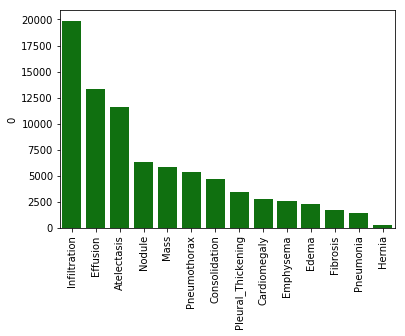

In [8]:
clean_labels = xray_data[dummy_labels].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [9]:
# create vector as ground-truth, will use as actuals to compare against our predictions later
xray_data['target_vector'] = xray_data.apply(lambda target: [target[dummy_labels].values], 1).map(lambda target: target[0])

In [10]:
xray_data.head() # take a look to ensure target_vector makes sense

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,full_path,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,target_vector
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/images_001/images/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/images_001/images/00000001_001.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
# split the data into a training and testing set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(xray_data, test_size = 0.2, random_state = 1993)

# quick check to see that the training and test set were split properly
print('training set - # of observations: ', len(train_set))
print('test set - # of observations): ', len(test_set))
print('prior, full data set - # of observations): ', len(xray_data))

training set - # of observations:  89696
test set - # of observations):  22424
prior, full data set - # of observations):  112120


In [12]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.3,
        rotation_range=25,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True)

Using TensorFlow backend.


In [13]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [14]:
image_size = (128, 128) # image re-sizing target
train_gen = flow_from_dataframe(data_gen, train_set, path_col = 'full_path', y_col = 'target_vector', target_size = image_size, color_mode = 'grayscale', batch_size = 32)
valid_gen = flow_from_dataframe(data_gen, test_set, path_col = 'full_path', y_col = 'target_vector', target_size = image_size, color_mode = 'grayscale', batch_size = 128)

# define test sets
test_X, test_Y = next(flow_from_dataframe(data_gen, test_set, path_col = 'full_path', y_col = 'target_vector', target_size = image_size, color_mode = 'grayscale', 
                                          batch_size = 2048))

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 89696 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 22424 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 22424 images


In [15]:
# Import relevant libraries
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Create CNN model
# Will use a combination of convolutional, max pooling, and dropout layers for this purpose
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = test_X.shape[1:]))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
          
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
          
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 3))
model.add(Dropout(0.2))

# add in fully connected dense layers to model, then output classifiction probabilities using a softmax activation function
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(dummy_labels), activation = 'softmax'))

# compile model, run summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
__________

In [16]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only = True)
callbacks_list = [checkpointer]

In [17]:
model.fit_generator(generator = train_gen, steps_per_epoch = 20, epochs = 1, callbacks = callbacks_list, validation_data = (test_X, test_Y))

Epoch 1/1
20/20 [==============================] - 17s 872ms/step - loss: 1.8076 - acc: 0.1859 - val_loss: 1.7603 - val_acc: 0.1294

Epoch 00001: val_loss improved from inf to 1.76033, saving model to weights.best.01-1.76.hdf5


In [18]:
quick_model_predictions = model.predict(test_X, batch_size = 64, verbose = 1)

2048/2048 [==============================] - 0s 176us/step


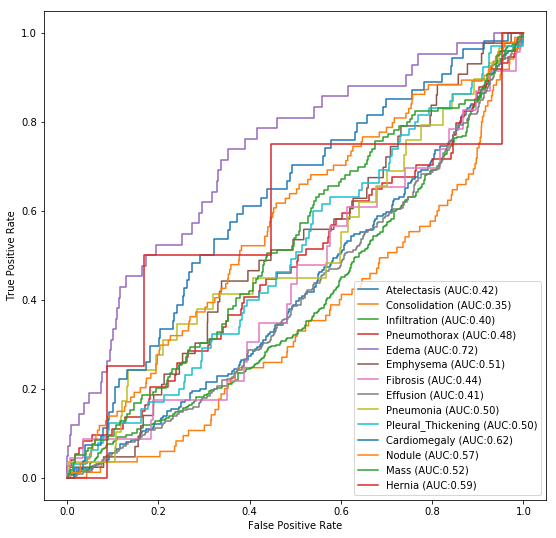

In [19]:
from sklearn.metrics import roc_curve, auc

# create plot
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (i, label) in enumerate(dummy_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), quick_model_predictions[:,i])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

# Set labels for plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('quick_trained_model.png')

Epoch 1/10
50/50 [==============================] - 42s 838ms/step - loss: 1.6744 - acc: 0.1319 - val_loss: 1.6864 - val_acc: 0.1294

Epoch 00001: val_loss improved from 1.76033 to 1.68640, saving model to weights.best.01-1.69.hdf5
Epoch 2/10
50/50 [==============================] - 42s 848ms/step - loss: 1.6722 - acc: 0.1444 - val_loss: 1.6632 - val_acc: 0.1294

Epoch 00002: val_loss improved from 1.68640 to 1.66324, saving model to weights.best.02-1.66.hdf5
Epoch 3/10
50/50 [==============================] - 43s 865ms/step - loss: 1.6432 - acc: 0.1425 - val_loss: 1.5950 - val_acc: 0.1294

Epoch 00003: val_loss improved from 1.66324 to 1.59503, saving model to weights.best.03-1.60.hdf5
Epoch 4/10
50/50 [==============================] - 42s 843ms/step - loss: 1.6530 - acc: 0.1500 - val_loss: 1.6030 - val_acc: 0.1294

Epoch 00004: val_loss did not improve from 1.59503
Epoch 5/10
50/50 [==============================] - 43s 854ms/step - loss: 1.6367 - acc: 0.1431 - val_loss: 1.5915 - va

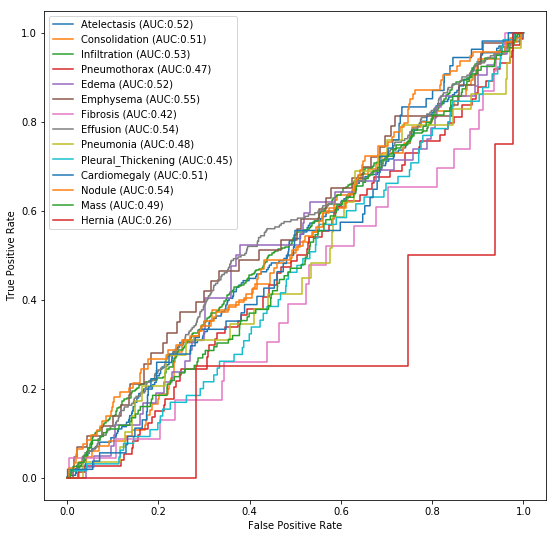

In [20]:
model.fit_generator(generator = train_gen, steps_per_epoch = 50, epochs = 10, callbacks = callbacks_list, validation_data = (test_X, test_Y))

deep_model_predictions = model.predict(test_X, batch_size = 64, verbose = 1)

# create plot
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (i, label) in enumerate(dummy_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), deep_model_predictions[:,i])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

# Set labels for plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('deep_trained_model.png')

In [21]:
import cv2
def preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
    img_resized = cv2.resize(img, target_size)  # Resize the image to target size
    img_array = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Select a random image from the test set
sample_image_path = test_set['full_path'].iloc[0]  # Replace 0 with any index to test specific images
ground_truth_vector = test_set['target_vector'].iloc[0]  # Get ground truth vector for this image

# Preprocess the image
preprocessed_image = preprocess_image(sample_image_path)

# Predict using the trained model
prediction = model.predict(preprocessed_image)[0]

# Map predictions and ground truth to labels
predicted_labels = {label: prediction[i] for i, label in enumerate(dummy_labels)}
ground_truth_labels = {label: ground_truth_vector[i] for i, label in enumerate(dummy_labels)}

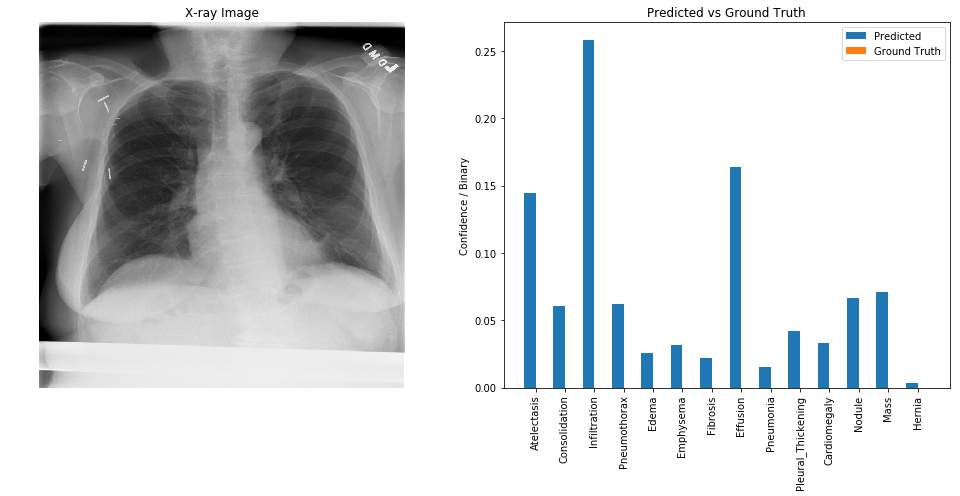

In [22]:
# Sort labels by confidence for better visualization
predicted_labels = dict(sorted(predicted_labels.items(), key=lambda x: x[1], reverse=True))

# Plot the image, predictions, and ground truth
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Display the image
ax[0].imshow(cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
ax[0].axis('off')
ax[0].set_title("X-ray Image")

# Display the prediction vs ground truth
bar_width = 0.4
index = np.arange(len(dummy_labels))

# Plot predictions
ax[1].bar(index - bar_width / 2, [predicted_labels[label] for label in dummy_labels], bar_width, label='Predicted')
# Plot ground truth
ax[1].bar(index + bar_width / 2, [ground_truth_labels[label] for label in dummy_labels], bar_width, label='Ground Truth')

ax[1].set_xticks(index)
ax[1].set_xticklabels(dummy_labels, rotation=90)
ax[1].set_ylabel("Confidence / Binary")
ax[1].set_title("Predicted vs Ground Truth")
ax[1].legend()

plt.tight_layout()
plt.show()